## Computing Singular Value Decomposition (SVD) Through Power Iterations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

### Read in Data

In [2]:
df=pd.read_csv('data/Consumo_cerveja.csv', decimal=',')
df =  df.dropna()
df.shape

(365, 7)

In [28]:
def plot_two(x, y, x_label="Maximal temperature ($\degree$C)", y_label="Consuption (liters)", 
              alpha=0.3, draw_axes=False):
    
    x = [float(ele) for ele in x]
    y = [float(ele) for ele in y]
    plt.scatter(x, y, alpha=alpha)

    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # Assure that ticks are displayed with a specific step
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    
    if draw_axes:
        # draw axes
        plt.axhline(0, c='#d6d6d6', zorder=0)
        plt.axvline(0, c='#d6d6d6', zorder=0)

    # assure x and y axis have the same scale
    plt.axis('equal')
    plt.show()

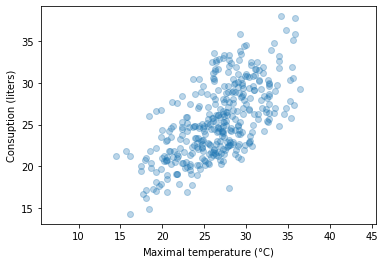

In [59]:
plot_two( df['Temperatura Maxima (C)'],
          df['Consumo de cerveja (litros)'])

In [81]:
cols = df.columns
all_d = []
for col in cols[1:4]:
    print(col)
    all_d.append([float(ele) for ele in df[col]])
data = np.array(all_d).T
# data = [all_d[2], all_d[-1]]
# data = np.array(data).T
data.shape

Temperatura Media (C)
Temperatura Minima (C)
Temperatura Maxima (C)


(365, 3)

In [62]:
# Normalization
data_norm=data.copy()
data_norm -= data.mean(axis=0)
cov = np.cov(data_norm, rowvar=False)

if the data are centered, the SVD can be used to perform a spectral decomposition of the sample covariance matrix where the right singular vectors correspond to the eigen vectors of the covariance matrix

$$\lambda_i = \frac{s_i^{2}}{n-1}, n=365. \text{(in our case)}$$
$$s_i = \sqrt{(n-1)\lambda_i}$$

https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

### Normalized Power Iteration

In [52]:
def norm_power_iteration(A, epsilon=1e-10):
    d = A.shape[0]
    vec_old = np.ones(d) / np.sqrt(d)
    val_old = np.linalg.norm(vec_old)
    
    while True:
        vec_new = A @ vec_old
        val_new = np.linalg.norm(vec_new)
        vec_new /= val_new
        if np.abs(val_new - val_old) < epsilon:
            break
        vec_old = vec_new
        val_old = val_new
    return val_new, vec_new

In [53]:
def svd_1d(A, epsilon=1e-10):
    ''' The one-dimensional SVD '''
 
    n, m = A.shape # (365, # of features)
    x = np.ones(m)/m
    vec_old = x
    val_old = np.linalg.norm(vec_old)
    B = A.T @ A # do power iteration on matrix B...B is a square matrix
 
    while True:
        vec_new = B @ vec_old
        val_new = np.linalg.norm(vec_new)
        vec_new /= val_new
        if np.abs(val_new - val_old) < epsilon:
            break
        vec_old = vec_new
        val_old = val_new
    return np.sqrt(val_new), vec_new

In [63]:
eigen_val, eigen_vec = norm_power_iteration(cov)
eigen_val, eigen_vec

(31.20734500851459, array([0.69671145, 0.71735149]))

In [65]:
eigen_val, eigen_vec = svd_1d(data_norm)
eigen_val, eigen_vec

(106.5808312179067, array([0.6967114 , 0.71735154]))

In [64]:
u, s, v=np.linalg.svd(data_norm)
s, v

(array([106.58083122,  49.69559601]),
 array([[-0.69671139, -0.71735154],
        [-0.71735154,  0.69671139]]))

In [66]:
#lets plot dominant eigenvector
def plot_eigenvectors(eigen_vecs, eigen_values, colors=["#FF8177", "orange"]):
    plt.title('Convariance Matrix First Component Visualization')
    for i, eigen_vec in enumerate(eigen_vecs):
        plt.quiver(0, 0,
           2 * np.sqrt(eigen_values[i]) * eigen_vec[0], 2 * np.sqrt(eigen_values[i]) * eigen_vec[1],
           color=colors[i], angles="xy", scale_units="xy", scale=1,
           zorder=2, width=0.011)

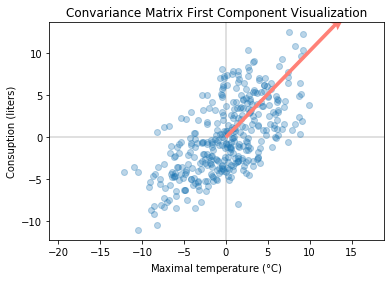

In [67]:
plot_eigenvectors([eigen_vec], [eigen_val], colors=["#FF8177", "orange"])
plot_two(data_norm[:, 0], data_norm[:, 1], draw_axes=True)

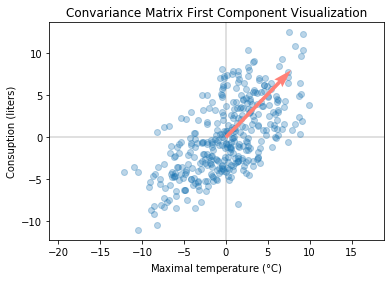

In [68]:
plot_eigenvectors([np.absolute(v[0])], [s[0]**2 / (364)], colors=["#FF8177", "orange"])
plot_two(data_norm[:, 0], data_norm[:, 1], draw_axes=True)

### SVD for First K Singular Values (Normalized Power Interation)

Say you start with the matrix $A$ and you compute $v_1$. You can use $v_1$ to compute $u_1$ and $\sigma_1(A)$. Then you want to ensure you’re ignoring all vectors in the span of $v_1$ for your next greedy optimization, and to do this you can simply subtract the rank 1 component of $A$ corresponding to $v_1$, i.e., set $$A' = A - \sigma_1(A) u_1 v_1^T$$ Then it’s easy to see that $\sigma_1(A') = \sigma_2(A)$ and basically all the singular vectors shift indices by 1 when going from $A$ to $A'$. Then you repeat.

https://jeremykun.com/2016/05/16/singular-value-decomposition-part-2-theorem-proof-algorithm/

In [82]:
u, s, v=np.linalg.svd(data)
s, v

(array([739.00815818,  36.87914226,  10.2555066 ]),
 array([[-0.55470271, -0.45556799, -0.69624903],
        [ 0.12505716,  0.78163498, -0.61107075],
        [ 0.82259687, -0.42603353, -0.376603  ]]))

In [83]:
def svd_power_iter(A, k=None, epsilon=1e-10): 
    """returns k dominant eigenvalues and eigenvectors of matrix A"""
    A = np.array(A, dtype=float)
    n, m = A.shape # (365, # of features)
        
    svd_so_far = []
    if k is None:
        k = min(n, m)

    for i in range(k):
        matrix_for_1d = A.copy()

        for singular_value, u, v in svd_so_far[:i]:
            matrix_for_1d -= singular_value * u.reshape(n, 1) @ v.reshape((1,m))
        
        x, v = svd_1d(matrix_for_1d, epsilon=epsilon)  # next singular vector
        u_unnormalized = matrix_for_1d @ v
        sigma = np.linalg.norm(u_unnormalized)  # next singular value
        u = u_unnormalized / sigma

        svd_so_far.append((sigma, u, v))

    singular_values, us, vs = [np.array(x) for x in zip(*svd_so_far)]
    return singular_values, us.T, vs

In [84]:
sp, up, vp = svd_power_iter(data)
sp, vp, up.shape

(array([739.00815818,  36.87914226,  10.2555066 ]),
 array([[ 0.55470271,  0.45556799,  0.69624903],
        [ 0.12505716,  0.78163498, -0.61107075],
        [ 0.82259687, -0.42603353, -0.376603  ]]),
 (365, 3))

In [86]:
print(np.allclose(np.absolute(u[:,:3]), np.absolute(up)))
print(np.allclose(np.absolute(v), np.absolute(vp)))
print(np.allclose(s, sp))

True
True
True


### SVD for First K Singular Values (Orthogonal Interation)

the eigenvalues of A are located on the main diagonal of R (singular vals)
And the columns of Q are the eigenvectors (each row of v)

In [87]:
def svd_orthogonal_iteration(A, k=None, epsilon=1e-15):
    n, m = A.shape
    if k is None:
        k=min(n, m)
        
    A_orig=A.copy()        
    
#     if n_orig > m_orig:
    A = A.T @ A # (365, 365)
    n, m = A.shape
#     elif n_orig < m_orig:
#         A = A @ A.T
#         n, m = A.shape
#     else:
#         n,m=n_orig, m_orig
    Q = np.random.rand(n, k)
    Q, _ = np.linalg.qr(Q)
    Q_prev = Q
 
    for i in range(1000):
        Z = A @ Q
        Q, R = np.linalg.qr(Z)
        # can use other stopping criteria as well 
        err = ((Q - Q_prev) ** 2).sum()
        Q_prev = Q
        if err < epsilon:
            break

    singular_values = np.sqrt(np.diag(R))
    v = Q.T
    #use property Values @ V = U.T@A => U=A@V@inv(Values)
    u = A_orig @ v.T @ np.linalg.inv(np.diag(singular_values))

    return u, singular_values, v

In [89]:
uo, so, vo = svd_orthogonal_iteration(data)
so, vo, uo.shape

(array([739.00815818,  36.87914226,  10.2555066 ]),
 array([[-0.55470271, -0.45556799, -0.69624903],
        [-0.12505716, -0.78163498,  0.61107075],
        [-0.82259687,  0.42603353,  0.376603  ]]),
 (365, 3))

In [90]:
print(np.allclose(np.absolute(u[:,:3]), np.absolute(uo)))
print(np.allclose(np.absolute(v), np.absolute(vo)))
print(np.allclose(s, so))

True
True
True


### SVD for First K Singular Values (Lanczos Algorithm)

In [91]:
def lanczos(L, x0, k):
    n, m = L.shape
    s = x0.shape[0]

    assert (n == m), "Matrix should be square !!"
    assert (n == s), "Initial vector has wrong shape !!"

    Q = np.zeros((n, k))

    ones = np.ones(n)
    ones = ones/np.linalg.norm(ones)

    x0 = x0 - ones * np.inner(ones,x0)

    ## Initialize q0 to zero vector and beta_0 to 0
    q0 = np.zeros_like(x0)

    ## Initialize q1 to normalized initial vector
    q1 = np.divide(x0, np.linalg.norm(x0))

    ## Lists to keep track of main diagonal and super-sub diagonal
    alpha = np.zeros((k,))
    beta = np.zeros((k + 1,))

    ## Loop through the size of the matrix
    for l in range(k):
        Q[:, l] = q1[:]
        ## Matrix-vector product
        u = L.dot(q1)

        ## Calculate alpha_l
        alpha[l] = np.dot(q1.T, u)

        ## Update u
        u = u - beta[l] * q0 - alpha[l] * q1

        ## Calculate beta_{l+1}
        beta[l + 1]  = np.linalg.norm(u)

        ## Set q_{l+1}
        q0[:] = q1[:]
        q1 = np.divide(u, beta[l + 1])

    T = np.diag(alpha, 0) + np.diag(beta[1:-1], -1) + np.diag(beta[1:-1], 1)

    return Q, T

def svd_lanczos(A, k=None, epsilon=1e-15):
    n, m = A.shape
    if k is None:
        k=min(n, m)
        
    A_orig=A.copy()        
    A = A.T @ A # (3,3)
    n, m = A.shape
    
    x0 = np.linspace(1, n, num = n)
    Q, T = lanczos(A, x0, k)

    singular_values = np.sqrt(np.diag(T))
    v = Q.T
    #use property Values @ V = U.T@A => U=A@V@inv(Values)
    u = A_orig @ v.T @ np.linalg.inv(np.diag(singular_values))

    return u, singular_values, v

In [92]:
ul, sl, vl = svd_orthogonal_iteration(data)
sl, vl, ul.shape

(array([739.00815818,  36.87914226,  10.2555066 ]),
 array([[-0.55470271, -0.45556799, -0.69624903],
        [-0.12505716, -0.78163498,  0.61107075],
        [-0.82259687,  0.42603353,  0.376603  ]]),
 (365, 3))

In [93]:
print(np.allclose(np.absolute(u[:,:3]), np.absolute(ul)))
print(np.allclose(np.absolute(v), np.absolute(vl)))
print(np.allclose(s, sl))

True
True
True


In [99]:
# check the results
print(np.allclose(np.absolute(u), np.absolute(up)))
print(np.allclose(np.absolute(v), np.absolute(vp)))
print(np.allclose(s, sp))

print(np.allclose(np.absolute(u), np.absolute(uo)))
print(np.allclose(np.absolute(v), np.absolute(vo)))
print(np.allclose(s, so))

print(np.allclose(np.absolute(u), np.absolute(ul)))
print(np.allclose(np.absolute(v), np.absolute(vl)))
print(np.allclose(s, sl))

True
True
True
True
True
True
True
True
True
